In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import wandb
import torch
import random
import pickle
import imageio
import librosa
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 0.9.16
torch version 2.3.0


In [4]:
# print(os.getenv('wandb_api_key'))

In [5]:
wandb.login(key=os.getenv('wandb_api_key'))

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Asus\.netrc


True

In [6]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Config

In [7]:
train_dir = Path('E:\data\BirdCLEF')

In [8]:
class CFG:
    DEBUG = False # True False

    # Competition Root Folder
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    DATA_DIR = train_dir / 'spectros'
    TRAN_CSV = train_dir / 'train_metadata.csv'
    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = train_dir / 'ckpt'

    num_workers = 12
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000

    image_size = 128
    
    ### split train and validation sets
    split_fraction = 0.95
    
    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  
    
    ### training
    BATCH_SIZE = 128
    # N_EPOCHS = 3 if DEBUG else 40
    N_EPOCHS = 20
    LEARNING_RATE = 1e-5
    
    ### set only one to True
    save_best_loss = False
    save_best_accuracy = True
    
    ### optimizer
    #   optimizer = 'adam'
    # optimizer = 'adamw'
    optimizer = 'rmsprop'
    
    weight_decay = 1e-6 # for adamw
    l2_penalty = 0.01 # for RMSprop
    rms_momentum = 0 # for RMSprop
    
    ### learning rate scheduler (LRS)
    scheduler = 'ReduceLROnPlateau'
    #   scheduler = 'CosineAnnealingLR'
    plateau_factor = 0.5
    plateau_patience = 3
    cosine_T_max = 4
    cosine_eta_min = 1e-8
    verbose = True

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    random_seed = 42

    comment = 'first'

mel_spec_params = {
    "sample_rate": CFG.SR,
    "n_mels": 128,
    "f_min": 20,
    "f_max": CFG.SR / 2,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "mel_scale" : "slaney"
}

CFG.mel_spec_params = mel_spec_params

sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:]
CFG.N_LABELS = len(CFG.LABELS)
print(f'# labels: {CFG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [9]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

In [10]:
meta_df = pd.read_csv(CFG.TRAN_CSV)
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [11]:
CFG.LABELS

Index(['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1',
       'aspfly1', 'aspswi1', 'barfly1', 'barswa',
       ...
       'whbwoo2', 'whcbar1', 'whiter2', 'whrmun', 'whtkin2', 'woosan',
       'wynlau1', 'yebbab1', 'yebbul3', 'zitcis1'],
      dtype='object', length=182)

### Load data

In [12]:
from dataset import spectro_dataset, bird_dataset

In [13]:
dset = bird_dataset(meta_df, CFG)

print(dset.__len__())

spect, label, = dset.__getitem__(0)
print(spect.shape, label.shape)
print(spect.dtype, label.dtype)

24459
torch.Size([3, 128, 313]) torch.Size([182])
torch.float32 torch.float32


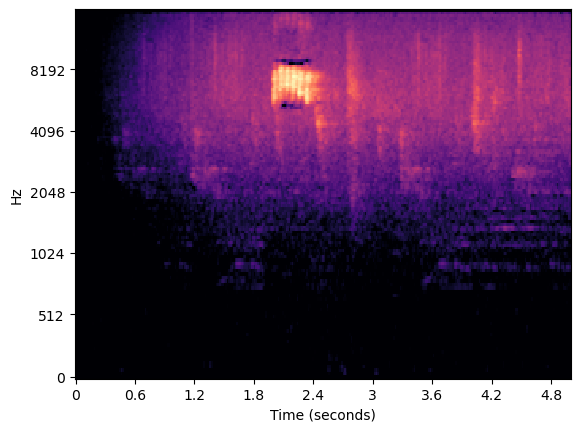

In [14]:
librosa.display.specshow(spect[0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

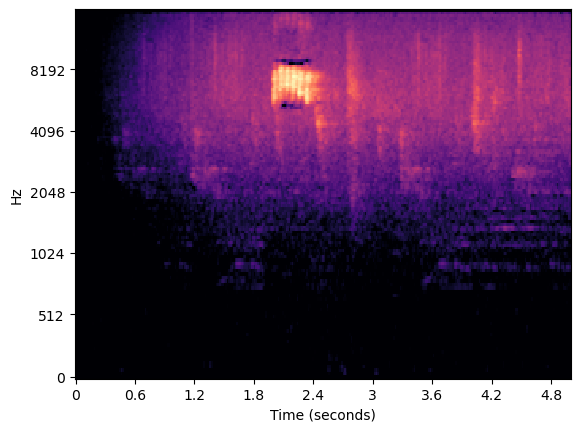

In [15]:
librosa.display.specshow(spect[0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

### Data Module

In [16]:
from dataset import spectro_dataset, bird_dataset

In [17]:
class wav_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, cfg=CFG, train_tfs=None, val_tfs=None):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        
        self.train_bs = cfg.BATCH_SIZE
        self.val_bs = cfg.BATCH_SIZE

        self.train_tfs = train_tfs
        self.val_tfs = val_tfs

        self.cfg = cfg
        
        self.num_workers = cfg.num_workers
        
    def train_dataloader(self):
        train_ds = bird_dataset(self.train_df, self.cfg, tfs=self.train_tfs)
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = bird_dataset(self.val_df, self.cfg, tfs=self.val_tfs)
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=1,
        )
        
        return val_loader

In [18]:
# class spectro_datamodule(pl.LightningDataModule):
#     def __init__(self, train_df, val_df, cfg=CFG):
#         super().__init__()
        
#         self.train_df = train_df
#         self.val_df = val_df
        
#         self.train_bs = cfg.BATCH_SIZE
#         self.val_bs = cfg.BATCH_SIZE
        
#         self.num_workers = cfg.num_workers
        
#     def train_dataloader(self):
#         train_ds = spectro_dataset(self.train_df, X, y)
        
#         train_loader = torch.utils.data.DataLoader(
#             train_ds,
#             batch_size=self.train_bs,
#             pin_memory=False,
#             drop_last=False,
#             shuffle=True,
#             num_workers=self.num_workers,
#         )
        
#         return train_loader
        
#     def val_dataloader(self):
#         val_ds = spectro_dataset(self.val_df, X, y)
        
#         val_loader = torch.utils.data.DataLoader(
#             val_ds,
#             batch_size=self.val_bs,
#             pin_memory=False,
#             drop_last=False,
#             shuffle=False,
#             num_workers=self.num_workers,
#         )
        
#         return val_loader

In [19]:
image_size = CFG.image_size

train_tfs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    # A.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.7),
    A.Normalize()
])

val_tfs = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

In [20]:
t_df = meta_df[:-100]
v_df = meta_df[-100:]

CFG2 = CFG
CFG2.BATCH_SIZE = 16
CFG2.num_workers = 2

dm = wav_datamodule(t_df, v_df, cfg=CFG2)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 128, 313]),
 torch.Size([16, 182]),
 torch.float32,
 torch.float32)

In [21]:
# librosa.display.specshow(x[0].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
# plt.show()

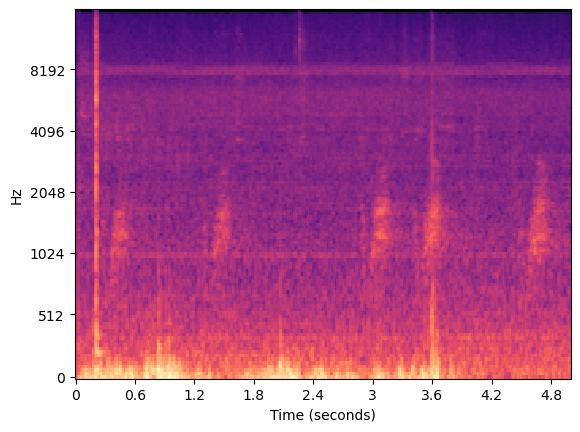

In [22]:
librosa.display.specshow(x[0].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [23]:
# img = x[0]
# img.shape, img.unsqueeze(dim=0).numpy().shape, img.expand(3, -1, -1).shape

In [24]:
# img.expand(3, -1, -1).permute(1, 2, 0).shape, img.expand(3, -1, -1).permute(1, 2, 0).numpy().transpose(2,0,1).shape

In [25]:
# train_tfs(image=img.numpy())

In [26]:
del dm

### Loss function

In [27]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [28]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Model

In [29]:
print('Number of models available: ', len(timm.list_models(pretrained=True)))
print('Number of models available: ', len(timm.list_models()))
# print('\nDensenet models: ', timm.list_models('eff*'))

Number of models available:  1329
Number of models available:  1032


In [30]:
backbone = 'eca_nfnet_l0'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

In [31]:
model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=5,
    out_indices=out_indices,
    )

In [32]:
# model.feature_info.

In [33]:
model.feature_info.channels()

[1536, 2304]

In [34]:
model.feature_info.channels()

[1536, 2304]

In [35]:
np.sum(model.feature_info.channels())

3840

In [36]:
spect.shape

torch.Size([3, 128, 313])

In [37]:
# foo = model(spect.unsqueeze(0))
# len(foo)

In [38]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg
        
        out_indices = (3, 4)

        self.criterion = FocalLossBCE()

        self.train_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)
        self.val_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)

        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, self.cfg.N_LABELS)

    def forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=self.cfg.LEARNING_RATE, weight_decay=CFG.weight_decay)

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch
        
        preds = self(x)
        
        loss = self.criterion(preds, y)
        
        if mode == 'train':
            self.train_acc(preds, y.argmax(1))
        else:
            self.val_acc(preds, y.argmax(1))
        
        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)
        # self.log(f'{mode}/kl_loss', kl_loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        self.log(f'train/acc', self.train_acc, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='val')
        self.log(f'val/acc', self.val_acc, on_step=True, on_epoch=True)
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.reset()
        self.val_acc.reset()


In [39]:
model = GeMModel(CFG)

eca_nfnet_l0


In [40]:
foo = model(x)

In [41]:
foo.shape

torch.Size([16, 182])

### Split

In [42]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [43]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=CFG.random_seed)
train_idx, val_idx = next(sss.split(meta_df.filename, meta_df.primary_label))

t_df = meta_df.iloc[train_idx]
v_df = meta_df.iloc[val_idx]

t_df.shape, v_df.shape

((22013, 12), (2446, 12))

### Train

In [44]:
# dm = wav_datamodule(t_df,v_df)
dm = wav_datamodule(t_df, v_df, CFG, train_tfs=train_tfs, val_tfs=val_tfs) 

In [45]:
len(dm.train_dataloader()), len(dm.val_dataloader())

(1376, 153)

In [46]:
model = GeMModel(CFG)

eca_nfnet_l0


In [47]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [48]:
wandb_logger = WandbLogger(
    name=f'{CFG.model_name} {CFG.LEARNING_RATE} {CFG.N_EPOCHS} eps {CFG.comment}',
    project='Bird-local',
    job_type='train',
    save_dir=CFG.RESULTS_DIR,
    # config=cfg,
)

In [49]:
loss_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/loss',
    dirpath=CFG.CKPT_DIR,
    filename='loss-{epoch:02d}-{val/loss:.2f}',
    save_top_k=1,
    mode='min',
)

In [50]:
CFG.device

'cuda'

In [51]:
trainer = pl.Trainer(
    max_epochs=CFG.N_EPOCHS,
    deterministic=True,
    accelerator=CFG.device,
    default_root_dir=CFG.RESULTS_DIR,
    gradient_clip_val=0.5, 
    # gradient_clip_algorithm="value",
    logger=wandb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | criterion    | FocalLossBCE       | 0     
1 | train_acc    | MulticlassAccuracy | 0     
2 | val_acc      | MulticlassAccuracy | 0     
3 | backbone     | FeatureListNet     | 21.8 M
4 | global_pools | ModuleList         | 2     
5 | neck         | BatchNorm1d        | 7.7 K 
6 | head         | Linear             | 699 K 
----------------------------------------------------
22.5 M    Trainable params
0         Non-trainable params
22.5 M    Total params
90.183    Total estimated model params size (MB)


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

C:\Users\Asus\.conda\envs\llms\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                               | 0/? [00:00<?, ?it/…

C:\Users\Asus\.conda\envs\llms\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [53]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/acc_epoch,▁▁▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇██
train/acc_step,▁▁▁▁▂▁▂▂▂▂▂▄▃▄▃▄▄▄▃▄▆▄▄▅▆▆▆▆▆▆▆▆▆▅▇▆█▇▇▇
train/loss_epoch,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,██▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▁▄▁▁▁▁▂▇▂█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃
val/acc_epoch,▁▁▁▂▃▄▄▅▆▆▆▇▇▇▇█████
val/acc_step,▂▁▂▁▃▁▁▂▄▃▄█▄▄▄▃▄▅▅▅▅▄▄▆▄▅▄▃▆▃▅▄▄▅▅▅▅▃▄▇
val/loss_epoch,█▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss_step,██▄▄▂▂▁▁▁▅▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19


### Predict

In [54]:
foo = model(x)
# foo = model(x.to(CFG.device))
foo.shape

torch.Size([16, 182])

In [55]:
foo[0]

tensor([ -6.5042,  -7.6409,  -8.4464,  -7.6505,  -6.4986,  -8.8519,  -8.7268,
         -8.0550,  -9.2320,  -8.0452,  -7.1090,  -8.7585,  -8.1568,  -9.2310,
         -8.1848,  -6.4512,  -9.3948,  -9.4905,  -7.2688,  -7.4815,  -7.6101,
         -9.1982,  -8.8577,  -8.8759,  -9.0676,  -8.4384,  -6.8355,  -8.5220,
         -6.6023,  -9.0408,  -9.7371,  -9.4368,  -6.7399,  -7.3462, -10.2596,
         -6.4463,  -8.1933,  -7.2793,  -7.3791,  -8.0044,  -7.4205,  -6.3711,
         -8.1624,  -7.6799,  -7.5387,  -8.1858,  -8.9866,  -9.7106,  -8.2543,
         -9.6689,  -7.6373,  -8.1278,  -9.8745,  -8.7955,  -8.6671,  -7.1408,
         -8.9215,  -6.1367,  -9.9340,  -8.6755,  -8.8786,  -8.0660,  -7.5077,
         -8.2590,  -6.9287,  -7.3808,  -9.1974,  -9.2798,  -8.4311,  -8.7815,
         -8.3043,  -8.2387,  -6.9706,  -7.0873,  -8.5509,  -9.6221,  -7.5357,
         -7.2730,  -8.5189,  -9.2113,  -7.0717,  -7.4221,  -7.7952,  -8.8275,
         -9.0073,  -8.3639,  -7.4832,  -6.9454,  -7.9354,  -9.09

In [56]:
torch.nn.functional.softmax(foo[0], dim=-1)

tensor([0.0194, 0.0062, 0.0028, 0.0062, 0.0195, 0.0019, 0.0021, 0.0041, 0.0013,
        0.0042, 0.0106, 0.0020, 0.0037, 0.0013, 0.0036, 0.0204, 0.0011, 0.0010,
        0.0090, 0.0073, 0.0064, 0.0013, 0.0018, 0.0018, 0.0015, 0.0028, 0.0139,
        0.0026, 0.0176, 0.0015, 0.0008, 0.0010, 0.0153, 0.0084, 0.0005, 0.0205,
        0.0036, 0.0089, 0.0081, 0.0043, 0.0078, 0.0221, 0.0037, 0.0060, 0.0069,
        0.0036, 0.0016, 0.0008, 0.0034, 0.0008, 0.0062, 0.0038, 0.0007, 0.0020,
        0.0022, 0.0103, 0.0017, 0.0280, 0.0006, 0.0022, 0.0018, 0.0041, 0.0071,
        0.0034, 0.0127, 0.0081, 0.0013, 0.0012, 0.0028, 0.0020, 0.0032, 0.0034,
        0.0122, 0.0108, 0.0025, 0.0009, 0.0069, 0.0090, 0.0026, 0.0013, 0.0110,
        0.0077, 0.0053, 0.0019, 0.0016, 0.0030, 0.0073, 0.0125, 0.0046, 0.0015,
        0.0080, 0.0089, 0.0013, 0.0074, 0.0062, 0.0114, 0.0054, 0.0013, 0.0023,
        0.0008, 0.0117, 0.0036, 0.0010, 0.0006, 0.0037, 0.0014, 0.0113, 0.0232,
        0.0040, 0.0046, 0.0039, 0.0024, 

In [57]:
torch.nn.functional.softmax(foo, dim=-1).max(dim=-1)

torch.return_types.max(
values=tensor([0.0346, 0.0586, 0.0825, 0.2027, 0.1126, 0.0843, 0.1019, 0.0601, 0.0947,
        0.0999, 0.1054, 0.0487, 0.0797, 0.1966, 0.0816, 0.0427],
       grad_fn=<MaxBackward0>),
indices=tensor([146,  14,   1,  10,   9,   4,  82,  40,   9,  57, 107, 176, 105, 181,
         57,  43]))

In [58]:
torch.nn.functional.softmax(foo, dim=-1).argmax(dim=-1)

tensor([146,  14,   1,  10,   9,   4,  82,  40,   9,  57, 107, 176, 105, 181,
         57,  43])

In [59]:
y.argmax(dim=-1)

tensor([100,  78,   4,  33, 120,  18, 143,  81,  10,  37, 163,  37,   9, 177,
         80,  13])

In [61]:
y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])